In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

from IPython.core.display import display, HTML
from IPython.display import Markdown as md

from matplotlib.ticker import EngFormatter

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def myround(x, base=5):
    return base * round(x/base)

# Estilo verde-rojito
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0 else 'black'
    if val < 0: color = 'green'
    return 'color: %s' % color

# Estilo gris
def color_gray(val):
    color = '.5'
    return 'color: %s' % color


In [3]:
display(HTML("<style>.rendered_html {font-size: 16px; line-height: 1.8; text-indent: 2rem}</style>"))
# display(HTML("<style>.rendered_html {  }</style>"))

In [4]:
frac = 0.04

In [5]:
yrs_pob_data = 3

In [6]:
aglo_labels = pd.read_csv('./data/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]

radio_ref = pd.read_csv('./data/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./data/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO','NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = pd.read_csv('./data/pobreza'+str(frac)+'.csv', index_col=0)
data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

pob_tot = len(data)/frac/yrs_pob_data
# pob_tot

# Ingresos de hogares, pobreza e indigencia. (Argentina)

Matias Iglesias

matuteiglesias@gmail.com


# Introducción. 

Este reporte presenta estimaciones de ingreso medio de hogares y personas en todo el territorio de la Republica Argentina a partir de la información en la Encuesta Permanente de Hogares (EPH) y el Censo de Población, Hogares y Viviendas de 2010, realizados por el Instituto Nacional de Estadística y Censos (INDEC).

Explotando las variables en común contenidas en ambas fuentes se entrenan algoritmos de clasificación y regresión que predicen los ingresos de muestras sintéticas de la población total consultada en Censo. O sea *machine learning* aplicado al Censo y las encuestas de hogares. Esto permite obtener valores de ingresos, incidencia de pobreza e indigencia y otras variables socioeconómicas segun características demográficas y habitacionales de las provincias, areas metropolitanas, departamentos, partidos, comunas u otras areas censales detalladas.

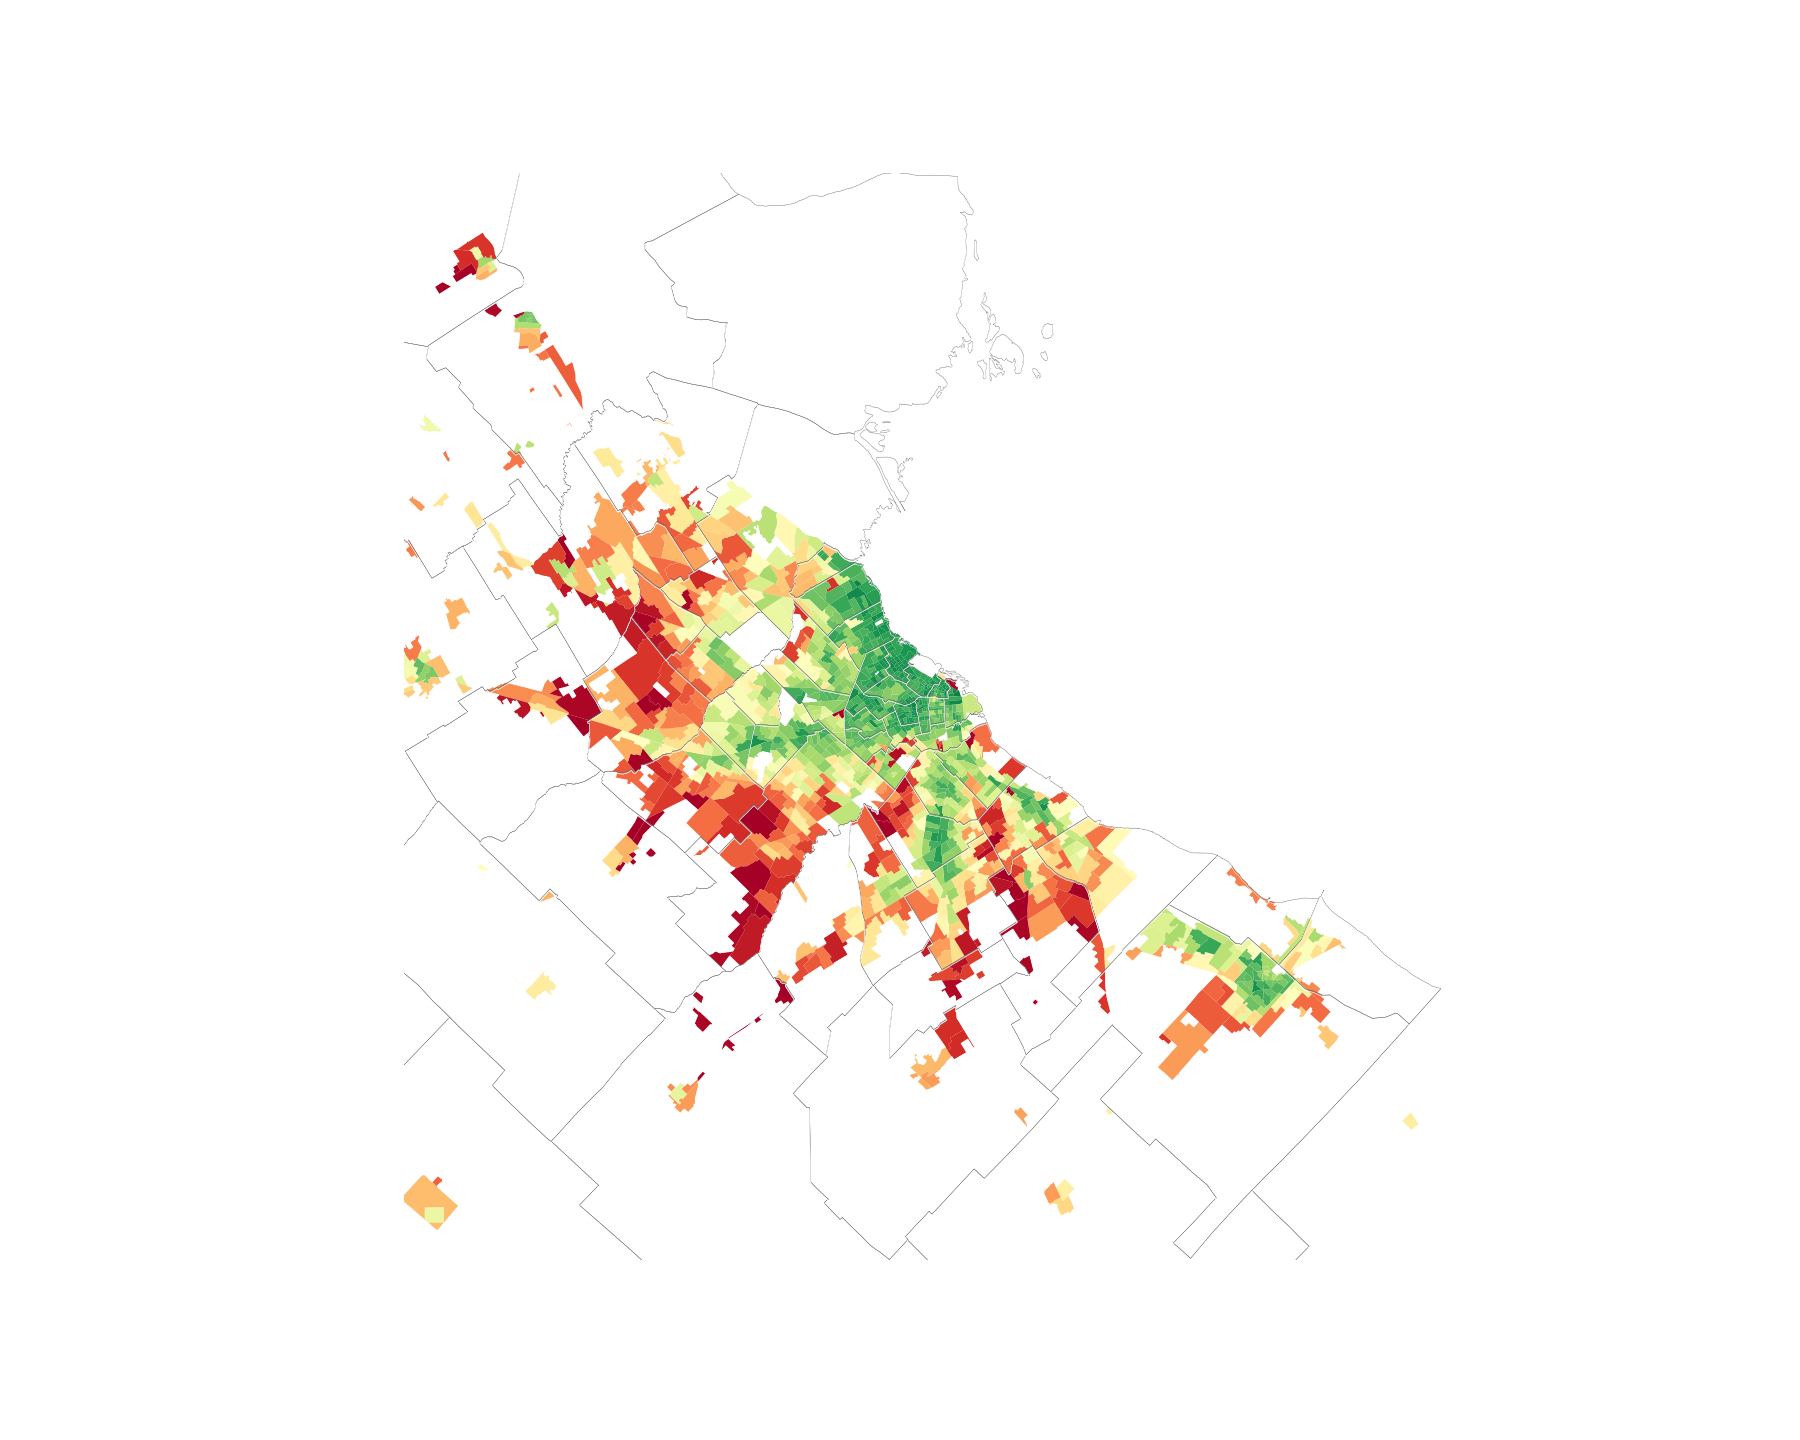

In [7]:
from IPython.display import Image
Image("./mapa_portada.png")

# Contenido
- Incidencia de pobreza e indigencia
- Evolucion semestral

    - Cantidades (miles)
    - Porcentajes

- Ingresos a precios constantes (ARS 2019Q2)
    - Deciles de ingreso
    - Lineas de Pobreza e indigencia

- Dependencia con otras variables
    - Habitaciones de la vivienda
    - Edad
    - Niveles educativos

- Dependencia geografica
    - Variacion regional
    - Por departamento y fraccion censal
    - Por Provincia
    - Por Region y aglomerado
    - Partidos y Comunas del AMBA
    
- Evolucion temporal por areas especificas.

- Lista de Aglomerados

# Incidencia de pobreza e indigencia
## Total Pais

In [8]:
# df = pd.read_csv('./data/cuadro_'+str(frac)+'_Total_pais_Q_n_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# n = df_.copy()
# n.columns = n.columns.to_period("6M")

# df = pd.read_csv('./data/cuadro_'+str(frac)+'_Total_pais_Q_pct_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# pct = df_.copy()
# pct.columns = pct.columns.to_period("6M")


# total_pais = pd.concat([pd.DataFrame(n.iloc[:, -1]),
#                         pd.DataFrame(pct.iloc[:, -1])], axis = 1)
# total_pais.columns = ['Cantidad (miles)', 'Porcentaje']

# x = total_pais
# x.index = x.index.droplevel(2)

cuadro5 = pd.read_csv('./data/cuadro4_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro5.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Porcentaje', 'Cantidad (miles)']

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate().rolling(4).mean()

x.round({'Cantidad (miles)': -2, 'Porcentaje': 1}).sort_index()

Porcentaje  Cantidad (miles)
Indigencia Hogares          9.4            1300.0
           Personas        12.7            5600.0
Pobreza    Hogares         33.3            4500.0
           Personas        42.9           19000.0

In [9]:

md("En el primer trimestre de 2019, la pobreza alcanza el {:.0f}".format(x.loc[('Pobreza', 'Hogares')].Porcentaje)+"% \
   de los hogares, donde viven el {:.0f}".format(x.loc[('Pobreza', 'Personas')].Porcentaje)+"% de las personas ({:.1f}".format(0.001*x.loc[('Pobreza', 'Personas')]['Cantidad (miles)'])+" millones). \
   La indigencia en el mismo periodo alcanza al {:.1f}".format(x.loc[('Indigencia', 'Hogares')].Porcentaje)+"% de los hogares, en donde viven {:.1f}".format(0.001*x.loc[('Indigencia', 'Personas')]['Cantidad (miles)'])+" millones de\
   personas ({:.1f}".format(x.loc[('Indigencia', 'Personas')].Porcentaje)+"%)")
     

En el primer trimestre de 2019, la pobreza alcanza el 33%    de los hogares, donde viven el 43% de las personas (19.0 millones).    La indigencia en el mismo periodo alcanza al 9.4% de los hogares, en donde viven 5.6 millones de   personas (12.7%)

## Evolucion Temporal

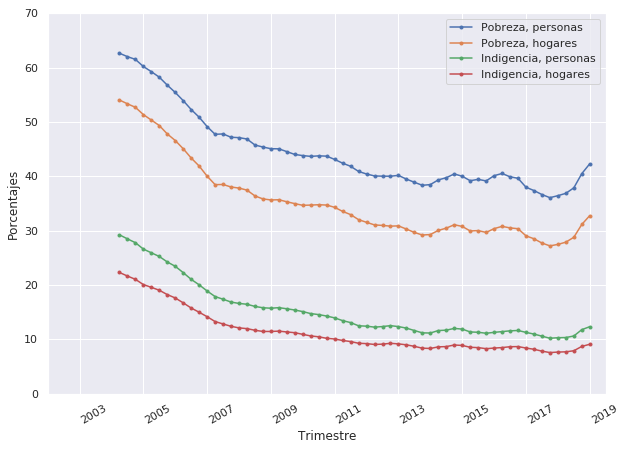

In [10]:
sns.set()

fig, ax = plt.subplots(1, figsize = (10, 7))

# Series
df_ = df.iloc[:, df.columns.get_level_values(1) == 'mean']
df_ = df_.T.reindex(df_.T.sum(1).sort_values(ascending = False).index).T
df_.columns = df_.columns.droplevel([1, 3])
df_.plot(ax = ax, marker = '.')


# df_2 = cuadro3.iloc[:, cuadro3.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
#             & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas']) & (cuadro5.columns.get_level_values(1) == 'mean')]
# df_2 = df_2.loc[df_2.index.get_level_values(1) == True]
# # Leave just time as index
# df_2 = df_2.unstack()
# df_2.index = pd.DatetimeIndex(df_2.index)
# df_2.columns = df_2.columns.droplevel([1, 3])
# # Rolling 4 trimestres de interpolado
# df_2 = df_2.resample('Q').mean().interpolate().rolling(4).mean()
# df_2.plot(ax = ax, marker = '.')

# Plot
ax.legend(loc = (1.02,0))
ax.set_ylabel('Porcentajes')
ax.set_ylim(0, 70)
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 30, ha="left" )
ax.set_xlim(pd.Timestamp('2002-02-15'), pd.Timestamp('2019-07-01'))
ax.set_xlabel('Trimestre')
ax.legend(['Pobreza, personas', 'Pobreza, hogares', 
           'Indigencia, personas', 'Indigencia, hogares'])

# # ANADIR SERIE CEDLAS
# serie_cedlas = pd.read_csv('./data/tornarolli_cedlas.csv', index_col=[0, 1], header = [0, 1])
# serie_cedlas = serie_cedlas.T[serie_cedlas.columns.get_level_values(1) == 'Comparable'].T
# serie_cedlas.columns = serie_cedlas.columns.get_level_values(0)
# serie_cedlas.index = pd.date_range("2003-09", periods=len(serie_cedlas), freq = '6M')
# (1.*serie_cedlas).plot(color = '.6', marker = '+', ax = ax)

plt.show()

Los puntos de este gráfico son los **valores promedios de los últimos 4 trimestres**. Previo a ese cálculo se interpola linealmente para tener los valores de los trimestres 2007-Q3, 2015-Q3, 2015-Q4, y 2016-Q1 para los cuales el INDEC no ofrece bases de microdatos.

En los últimos 15 años hay una tendencia de **descenso** de los niveles de pobreza.

***El dilema de 'Los numeros del INDEC'***

Existe un cuestionamiento de las series de índice de precios ofrecidas por INDEC entre 2007 y 2015. Los cálculos de los niveles de pobreza dependen de los valores en términos reales de las canastas alimentarias.

En este trabajo:
   * Se usan las canastas alimentaria y total regionales establecidas por INDEC desde 2016.
   * Construimos un indice de precios mensual de consenso entre las multiples mediciones disponibles en cada periodo.
   * El valor medio de las canastas de INDEC post 2016, a precios constantes se usa para los años anteriores.
   
De esta forma tenemos una regla fija para los niveles de pobreza en todo el período, **independiente de los índices de precios elaborados por INDEC**.

## Separacion 'aglomerados' vs resto del pais

In [11]:
#md("Los indicadores mas usados en determinar incidencia de pobreza se restringen a los llamados áglomerados urbanos'. La cifra de {:.0f}".format(x.loc[('Pobreza', 'Personas')].Porcentaje)+"% de las personas en pobreza difiere del 32.0% reportado por INDEC para el segundo semestre de 2018 los 33,6% reportados en el informe de UCA para 2018-Q3, principalmente por incluir la poblacion que vive fuera de los aglomerados urbanos.")

***La Encuesta de Hogares no releva zonas rurales***

El INDEC publica en informes semestrales los principales indicadores de pobreza e indigencia. La fuente primaria de información para ellos es la encuesta de hogares EPH. Sin embargo, esta última releva sólamente aglomerados urbanos grandes, dejando en un punto ciego al casi 9% de la poblacion que vive en zona rural, ademas de otro 25% de las personas y hogares que no pertenecen a los aglomerados grandes. 

### Porcentajes
#### Niveles

In [12]:
# df = pd.read_csv('./data/cuadro_'+str(frac)+'_AGLO_si_Q_pct_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show.columns = show.columns.to_period("6M")
# show = show.interpolate(axis = 1)

# show.round(1).style.set_properties(**{'color': 'gray'}, subset=[show.columns[3]])


# # error relativo 0.01

In [13]:
cuadro3 = pd.read_csv('./data/cuadro2_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro3.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro5.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Fuera de aglomerados', 'Aglomerados']

x.round(1)

Fuera de aglomerados  Aglomerados
Indigencia Hogares                   12.1          7.8
           Personas                  16.5         10.4
Pobreza    Hogares                   39.6         29.8
           Personas                  50.0         38.7

***Posible sobreestimacion de pobreza rural***

A la espera de una mejor solución (es decir, que se implemente un muestreo directo de la poblacion fuera de aglomerados), asumimos que ésta es equivalente a la relevada en los centros urbanos. Ciertamente esto puede conllevar a errores sistemáticos. por dar un ejemplo, el nivel educativo en las zonas rurales es significativamente menor. En la ciudad este es un signo de peores condiciones de trabajo e ingresos, pero no necesariamente esto es así en un entorno rural. 

Si nos basamos en niveles educativos podríamos facilmente sobreestimar la pobreza rural, y por lo tanto el total nacional. 
Al presentar los resultados desagregados geograficamente este tema puede salvarse.

In [14]:
startyr = 2003
endyr = 2020


***Serie Temporal***


In [15]:
# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

show.columns = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in show.columns])

show.T.round(1)

2003  2004  2005  2006  2007  2008  2009  \
Indigencia Hogares  Resto        29.7  27.6  24.1  20.2  16.7  15.7  15.4   
                    Aglomerados  19.2  17.3  14.9  12.0  10.0   9.1   8.9   
           Personas Resto        38.2  35.8  31.6  26.8  22.7  21.6  21.1   
                    Aglomerados  25.0  23.1  19.9  16.0  13.4  12.4  12.0   
Pobreza    Hogares  Resto        64.0  62.0  56.8  50.4  45.7  43.7  42.9   
                    Aglomerados  48.7  47.5  42.7  37.1  33.7  31.4  30.5   
           Personas Resto        72.0  70.0  65.7  59.6  55.3  54.0  52.9   
                    Aglomerados  57.4  56.5  51.5  45.7  42.4  40.3  38.8   

                                 2010  2011  2012  2013  2014  2015  2016  \
Indigencia Hogares  Resto        14.0  12.5  12.4  11.1  11.8  10.7  11.0   
                    Aglomerados   8.0   7.5   7.5   6.9   7.4   6.9   7.4   
           Personas Resto        19.7  17.0  16.8  15.0  16.0  14.5  14.9   
                    Aglomerados  11.1   9.9  10.0   9.0   9.7   9.1   9.7   
Pobreza    Hogares  Resto        42.6  38.9  37.5  35.3  37.5  35.4  36.2   
                    Aglomerados  30.3  28.1  27.1  25.7  27.5  26.4  27.0   
           Personas Resto        52.6  49.0  47.7  45.9  48.2  46.3  46.7   
                    Aglomerados  38.5  36.1  35.5  33.9  35.9  34.9  35.5   

                                 2017  2018  2019  
Indigencia Hogares  Resto         9.9  11.4  12.1  
                    Aglomerados   6.3   7.2   7.8  
           Personas Resto        13.5  15.7  16.5  
                    Aglomerados   8.2   9.5  10.4  
Pobreza    Hogares  Resto        32.9  37.2  39.6  
                    Aglomerados  24.0  27.7  29.8  
           Personas Resto        43.0  47.9  50.0  
                    Aglomerados  31.9  36.1  38.7

In [16]:
show = df.diff(4).groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)
show.columns = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in show.columns])


show.T.round(1).style.applymap(color_negative_red)

El ultimo minimo para todas las series de pobreza e indigencia se da en el segundo semestre de 2017.

### Cantidades (miles)
### Niveles

In [17]:
# # Escala crecimiento poblacional para cantidades... No se usa mas porque ahora los archivos ya vienen escalados

# escala = pd.read_csv('./data/escala_poblacion.csv')
# escala.index = pd.DatetimeIndex(pd.date_range(start = '2010', freq='Y', periods = len(escala))+ pd.DateOffset(days=-184) )
# escala = escala[['r2018']].resample('6M').interpolate().loc['2014':'2018']

In [18]:
# md("En el tercer trimestre de 2018, la pobreza alcanza {:.1f}".format(0.001*x.loc[('Pobreza', 'Personas')]['Cantidad (miles)'])+" millones de personas en todo el pais. \
#    \n\
#    La indigencia en el mismo periodo alcanza {:.1f}".format(0.001*x.loc[('Indigencia', 'Personas')]['Cantidad (miles)'])+" millones de personas\
#    \n\
#    A continuación la desagregacion entre aglomerados y resto del país. ")

In [19]:
# df = pd.read_csv('./data/cuadro_'+str(frac)+'_AGLO_si_Q_n_ARG', index_col=[0, 1], header = [0, 1]).drop_duplicates().unstack(0, 1)
# df.index = pd.to_datetime(df.index)

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show = (show.T*escala.values).T
# show.columns = show.columns.to_period("6M")
# show = show.interpolate(axis = 1)

# myround(show, 20).style.set_properties(**{'color': 'gray'}, subset=[show.columns[3]])


# # Redondear en decenas de miles? al menos..



In [20]:
cuadro3 = pd.read_csv('./data/cuadro2_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro3.iloc[:, cuadro5.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro5.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro5.columns.get_level_values(1).isin(['sum'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.iloc[-1].unstack([3, 1])
x.columns = ['Fuera de aglomerados', 'Aglomerados']

myround(x, 20).astype(int)
# Error es 10mil en pobreza hogares, 50mil en pobreza personas


Fuera de aglomerados  Aglomerados
Indigencia Hogares                    580          660
           Personas                  2700         2900
Pobreza    Hogares                   1920         2540
           Personas                  8180        10780

***Serie Temporal***

In [21]:
# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

myround(show.T, 20).astype(int)

2003   2004   2005   2006   2007  2008  2009  \
                    AGLO_si                                                  
Indigencia Hogares  False     1220   1140   1000    860    720   680   660   
                    True      1380   1260   1100    900    760   700   680   
           Personas False     5240   4980   4440   3820   3260  3140  3100   
                    True      5840   5440   4760   3860   3280  3060  3020   
Pobreza    Hogares  False     2620   2560   2360   2120   1940  1880  1860   
                    True      3520   3480   3160   2780   2540  2400  2360   
           Personas False     9900   9760   9240   8480   7940  7840  7740   
                    True     13380  13340  12320  11020  10380  9940  9700   

                             2010  2011  2012  2013  2014  2015  2016  2017  \
                    AGLO_si                                                   
Indigencia Hogares  False     620   560   560   500   540   500   520   460   
                    True      620   600   600   560   600   560   620   520   
           Personas False    2920  2540  2540  2300  2480  2280  2360  2180   
                    True     2800  2520  2600  2340  2560  2440  2620  2240   
Pobreza    Hogares  False    1860  1720  1680  1600  1720  1640  1700  1560   
                    True     2360  2220  2160  2080  2240  2180  2240  2020   
           Personas False    7800  7340  7240  7020  7460  7280  7420  6920   
                    True     9740  9240  9240  8860  9520  9360  9560  8700   

                             2018   2019  
                    AGLO_si               
Indigencia Hogares  False     540    580  
                    True      600    660  
           Personas False    2540   2700  
                    True     2620   2900  
Pobreza    Hogares  False    1780   1920  
                    True     2340   2540  
           Personas False    7800   8180  
                    True     9960  10780

In [22]:
show = df.diff(4).groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.index = range(startyr, endyr)

show.T.round(-1).style.applymap(color_negative_red)

In [23]:
nuevos_pobres = show.iloc[-4:]['Pobreza']['Personas'].sum().sum()
nuevos_indigs = show.iloc[-4:]['Indigencia']['Personas'].sum().sum()

md("Las estimaciones dan cuenta que en 2019 habrá {:.1f}".format(0.001*nuevos_pobres)+" millones de pobres más que en 2015. \
   Además habrá {:.1f}".format(0.001*nuevos_indigs)+" millones de nuevos indigentes. Los niveles de pobreza en 2019 igualan a los de 2008.")

Las estimaciones dan cuenta que en 2019 habrá 4.5 millones de pobres más que en 2015.    Además habrá 1.4 millones de nuevos indigentes. Los niveles de pobreza en 2019 igualan a los de 2008.

## Ingresos a precios constantes (ARS 2019-Q4)

Los valores monetarios reportados son en todos los casos en pesos argentinos (AR$) a valores constantes de 2019-Q4.

### Percentiles de ingreso
(Personas mayores de 24)

In [24]:
# #JIC

# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# import numpy as np

# from IPython.display import Markdown as md

# import numpy as np
# from matplotlib.ticker import EngFormatter

# data = pd.read_csv('./data/pobreza'+str(frac)+'.csv', index_col=0)
# data.nunique()

In [25]:
# import numpy as np
# s, bins_persona = pd.qcut(data.loc[data.P03 > 24].P47T_persona, 9, retbins=True, duplicates = 'drop')
# s, bins_hogares = pd.qcut(data.groupby('HOGAR_REF_ID').first().P47T_hogar, 9, retbins=True)
# df = pd.DataFrame([bins_persona[1:-1], bins_hogares[1:-1]], index = ['Ingreso Persona', 'Ingreso Hogar']).T
# # df.index = np.array([ 1, 2,  3,  4,  'mediana', 6,  7,  8,  9])
# # myround(df, 250).astype(int)
# df
# # Error +- 300 pe

In [26]:
def plot_dist(data, variable = 'P47T_hogar', xmin = 0, titulo = 'Title'):
    fig, ax = plt.subplots(1, figsize = (13, 6))

    no_pobres_hist = np.repeat(data.loc[data.Pobreza == False][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    pobres_hist = np.repeat(data.loc[(data.Pobreza) & (~data.Indigencia)][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    indig_hist = np.repeat(data.loc[data.Indigencia][['HOGAR_REF_ID', variable]].drop_duplicates()[variable].values, 1/frac/yrs_pob_data)
    hist_data = [indig_hist, pobres_hist, no_pobres_hist]
    plt.hist(hist_data, np.arange(xmin, 250000, 5000), stacked=True, alpha = .5)
    
    ax.legend(['Indigentes', 'Pobres no indigentes', 'No pobres'])
    ax.axvline(0, c = 'k')
    ax.yaxis.set_major_formatter(EngFormatter())

    plt.xlim(xmin, 250000)
    plt.ylim(0, 1e6)
    # plt.yscale('log')
    plt.ylabel('Cantidad \n total nacional por bin de AR$ 5000')
    plt.xlabel(titulo)

    plt.show()

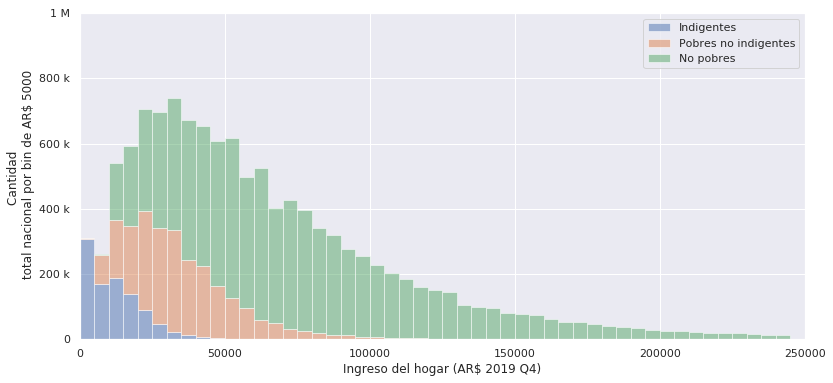

In [27]:
import numpy as np
from matplotlib.ticker import EngFormatter

plot_dist(data.groupby('HOGAR_REF_ID').first().reset_index(), variable = 'P47T_hogar', xmin = 0, 
          titulo = 'Ingreso del hogar (AR$ 2019 Q4)')

# plot_dist(data.loc[(data['P03'] > 24) & (data['P03'] > 34)], variable = 'P47T_persona', xmin = 0, 
#           titulo = 'Ingreso del hogar (AR$ 2019 Q4)')

## Lineas de Pobreza e indigencia

#### Total Pais

In [28]:
from IPython.display import display, HTML
# def pretty_print(df):
#     return display(HTML(df.to_html().replace("\\n","<br>")))

def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

In [29]:
# tabla_semestral = pd.read_csv('./data/tabla_semestral.csv', index_col=0, header = [0, 1])
# table = tabla_semestral.drop(['PERSONA_REF_ID', 'CBA','CBT'], axis = 1)
# table = table.iloc[:, table.columns.get_level_values(1) != 'sum']
# table.index = pd.to_datetime(table.index, infer_datetime_format=True)
# table.index = table.index.to_period("6M")

# table[('Pobreza', 'mean')] = 100*table[('Pobreza', 'mean')]
# table[('Indigencia', 'mean')] = 100*table[('Indigencia', 'mean')]

# table.columns = pd.Index([('Ingreso Persona', 'promedio'), ('Ingreso Persona', 'mediana'),
#                 ('Ingreso Hogar', 'promedio'), ('Ingreso Hogar', 'mediana'),
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'), ('Ingreso Hogar sobre linea de pobreza', 'mediana'),
#                 ('Pobreza (personas)', '%'), ('Indigencia (personas)', '%')])

# pd_centered(table.round({('Ingreso Persona', 'promedio'): -2, ('Ingreso Persona', 'mediana'): -2,
#                 ('Ingreso Hogar', 'promedio'): -2, ('Ingreso Hogar', 'mediana'): -2,
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'): -2, ('Ingreso Hogar sobre linea de pobreza', 'mediana'): -2,
#                 ('Pobreza (personas)', '%'): 1, ('Indigencia (personas)', '%'): 1}))

\* En este cuadro, el calculo de ingresos medios incluye a toda la poblacion, tambien menores e inactivos.



## 'Linea de Pobreza'

Para este paso, se aplican la regla sugerida por INDEC de pobreza monetaria. 

**De donde sale***

Involucra usar un numero cercano a 2.5 que viene de la encuesta de Gastos de Hogares (ENGHO).
Es decir, esta es una linea de ~2.5 Canastas alimentarias. Este es un punto crucial ya que afecta el numerito final de resultado que vamos a tener. Los valores precisos van a estar en el apendix pero seria bueno tambien un calculo menos vulnerable al control. 
La canasta alimentaria al poder ser biologicamente establecida y con algunos estimadores economicos sencillos (cuanto cuesta comer lo necesario) es mas transparente. Tambien se presta a ser comparada en reglas internacionales, es decir sugerencias de valores PPP que representan un nivel medido de alimentacion.

***Como se calcula***
 - Se usan los 10 trimestres disponibles para entrenar. 
 - Los resultados del algoritmo de prediccion son ingresos de personas y hogares.
 - Nos permite predecir un output complicado, como puede ser una condicion en la ecuacion del hogar.
 - Aprovechamos que los ponderamientos se pueden lograr sampleando al azar de una muestra comprensiva (Censo 2010).
 - Se usan las proyecciones poblacionales por departamento (INDEC)
 - Todos los valores en pesos de 2019-Q4. Conviene deflactar mensualmente. 
 - Se usa promedio simple. En alta inflacion da cierto bias. Aunque igualmente, tambien nosotros perdemos idea de cuanto valia el peso en ese momento.
 
 

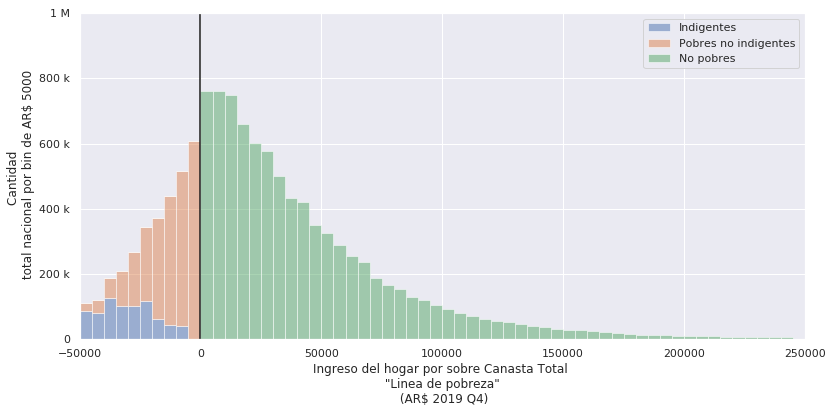

In [30]:
plot_dist(data, variable = 'gap_pobreza', xmin = -50000,
          titulo = 'Ingreso del hogar por sobre Canasta Total \n "Linea de pobreza" \n (AR$ 2019 Q4)')

***La linea de la canasta alimentaria***

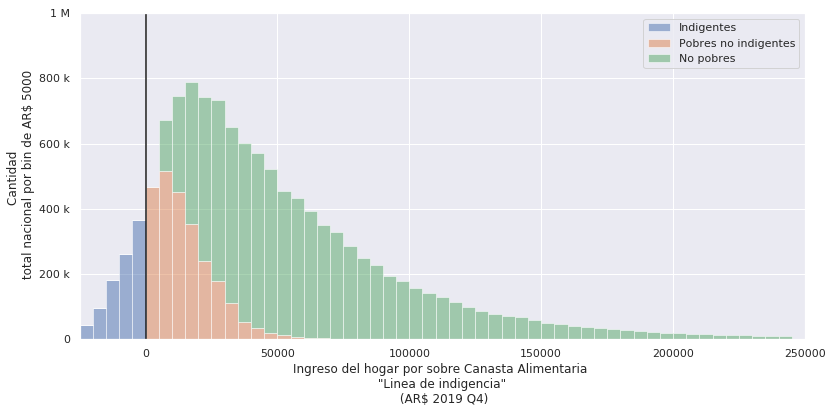

In [31]:
plot_dist(data, variable = 'gap_indigencia', xmin = -25000,
          titulo = 'Ingreso del hogar por sobre Canasta Alimentaria \n "Linea de indigencia" \n (AR$ 2019 Q4)')



Una vez que se hacen predicciones de ingresos y se calcula la 'Canasta Basica Alimentaria' de las personas de los hogares, calculamos la ecuacion en cada uno de los hogares y agregamos los resultados.

Esto nos deja ver una estructura detallada de la población de hogares que no llega pagar la canasta básica alimentaria de sus integrantes.

#### Canastas alimentaria y total, vs ingreso medio individual y de hogar.

Precios constantes de 2019-Q4. Los costos de canastas definidos post intervencion de 2016 se extienden hacia atras hasta 2003 para todos los calculos de pobreza.

In [32]:
# tabla_semestral_AGLOS = pd.read_csv('./data/tabla_semestral_AGLOS.csv', index_col=0, header = [0, 1])
# table = tabla_semestral_AGLOS.drop(['PERSONA_REF_ID', 'CBA','CBT'], axis = 1)
# table = table.iloc[:, table.columns.get_level_values(1) != 'sum']
# table.index = pd.to_datetime(table.index, infer_datetime_format=True)
# table.index = table.index.to_period("6M")

# table[('Pobreza', 'mean')] = 100*table[('Pobreza', 'mean')]
# table[('Indigencia', 'mean')] = 100*table[('Indigencia', 'mean')]

# table.columns = pd.Index([('Ingreso Persona', 'promedio'), ('Ingreso Persona', 'mediana'),
#                 ('Ingreso Hogar', 'promedio'), ('Ingreso Hogar', 'mediana'),
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'), ('Ingreso Hogar sobre linea de pobreza', 'mediana'),
#                 ('Pobreza (personas)', '%'), ('Indigencia (personas)', '%')])

# pd_centered(table.round({('Ingreso Persona', 'promedio'): -2, ('Ingreso Persona', 'mediana'): -2,
#                 ('Ingreso Hogar', 'promedio'): -2, ('Ingreso Hogar', 'mediana'): -2,
#                 ('Ingreso Hogar sobre linea de pobreza', 'promedio'): -2, ('Ingreso Hogar sobre linea de pobreza', 'mediana'): -2,
#                 ('Pobreza (personas)', '%'): 1, ('Indigencia (personas)', '%'): 1}))

In [33]:
cuadro5 = pd.read_csv('./data/cuadro4_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro5.iloc[:, cuadro5.columns.get_level_values(0).isin(['CBA', 'CBT', 'P47T_hogar', 'P47T_persona', 'gap', ])
                 & cuadro5.columns.get_level_values(1).isin(['median', ])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

show = df.groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel([1, 3])
show.columns = [('Canasta basica', 'alimentaria'), ('Canasta basica', 'total'), 
                ('Ingreso medio', 'hogar'), ('Ingreso medio', 'persona'),
                ('Brecha de hogares', 'todos'), ('Brecha de hogares', 'en pobreza')]
show.index = range(startyr, endyr)

# pd_centered(myround(show, 100).astype(int))

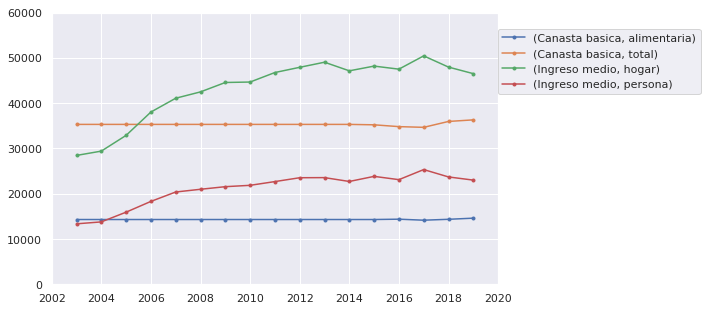

In [34]:
fig, ax = plt.subplots(figsize = (8, 5))
show.iloc[:, :4].plot(ax = ax, marker = '.')
plt.ylim(0, 6e4)
plt.xlim(2002, 2020)
ax.legend(loc = (1, .7))
plt.show()

## Variacion regional

In [35]:
# #JIC

# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# import numpy as np

# from IPython.display import Markdown as md

# import numpy as np
# from matplotlib.ticker import EngFormatter

data = pd.read_csv('./data/pobreza'+str(frac)+'.csv', index_col=0)
# data.nunique()

aglo_labels = pd.read_csv('./data/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = pd.read_csv('./data/radio_ref.csv').merge(aglo_labels)
dpto_region = pd.read_csv('./data/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)

In [36]:
### Matriz que da origen a las barritas de abajo.

data_hogares = data.groupby('HOGAR_REF_ID').first()
data_hogares = data_hogares.merge(radio_ref[['RADIO_REF_ID', 'Region', 'NOMPROV', 'NOMAGLO']].drop_duplicates())
data_hogares['Region'] = data_hogares['Region'].str.replace('Gran Buenos Aires', 'AMBA')
data_hogares['pctil'], bins_hogares = pd.qcut(data_hogares.P47T_hogar, 15, retbins=True)

df = data_hogares.groupby(['Region', 'pctil'])[['P47T_hogar']].count().unstack()
# df = df.div(df.sum(1), 0)#.round(3)

df_CABA = data_hogares.groupby(['NOMPROV', 'pctil'])[['P47T_hogar']].count().unstack().loc[['Ciudad Autónoma de Buenos Aires']]
# df_CABA = df_CABA.div(df_CABA.sum(1), 0)

df_GBA = data_hogares.groupby(['NOMAGLO', 'pctil'])[['P47T_hogar']].count().unstack().loc[['GBA']]
# df_GBA = df_GBA.div(df_GBA.sum(1), 0)

df = pd.concat([df_CABA, df_GBA, df])

df = df.reindex(['Noroeste', 'Noreste','Ciudad Autónoma de Buenos Aires', 'GBA', 'Cuyo', 'Pampeana', 'Patagónica'])

In [37]:
tot_reg = data_hogares.groupby('Region').count().iloc[:, 0]/frac/yrs_pob_data
totprovs = data_hogares.groupby('NOMPROV').count().iloc[:, 0]/frac/yrs_pob_data
totaglos = data_hogares.groupby('NOMAGLO').count().iloc[:, 0]/frac/yrs_pob_data

tot_hogares = pd.concat([tot_reg, totprovs, totaglos])

In [38]:
# Preparar gdf de pobreza por provincias

import geopandas as gpd
dptos_gdf = gpd.read_file('./../../Documents/censo_geo/pxdptodatosok.shp').drop([439])
dptos_gdf.crs = {'init': 'epsg:4326'} #latlong
dptos_gdf = dptos_gdf.to_crs({'init': 'epsg:3395'}) #lo dejamos en metrico

In [39]:
provs_gdf = dptos_gdf[['codpcia', 'geometry']].dissolve('codpcia')
provs_gdf.index = provs_gdf.index.astype(int)

pob_prov = data.groupby('PROV')[['Pobreza']].mean()
ingreso_mediano = data.loc[data.P03 > 24].groupby('PROV')[['P47T_persona', 'P47T_hogar']].median()
nomprovs = radio_ref[['PROV', 'NOMPROV', 'Region']].drop_duplicates().set_index('PROV')

provs_gdf = gpd.GeoDataFrame(pd.concat([nomprovs, ingreso_mediano, pob_prov, provs_gdf], axis = 1))

fancy_crs = {u'lat_0': -35,
 u'lon_0': -65,
 u'no_defs': True,
 u'proj': u'ortho',
 u'units': u'm',
 u'x_0': -65,
 u'y_0': -35,
 u'a' : 6371000, 
 u'b' : 6371000}
provs_gdf.crs = {'init': 'epsg:3395'}
provs_gdf = provs_gdf.to_crs({'init': 'epsg:4326'})
provs_gdf = provs_gdf.to_crs(fancy_crs)

El cuadro de deciles de ingreso muestra valores nacionales. Sin embargo ¿Cómo se distribuyen las poblaciones regionales entre estos grupos de ingreso?


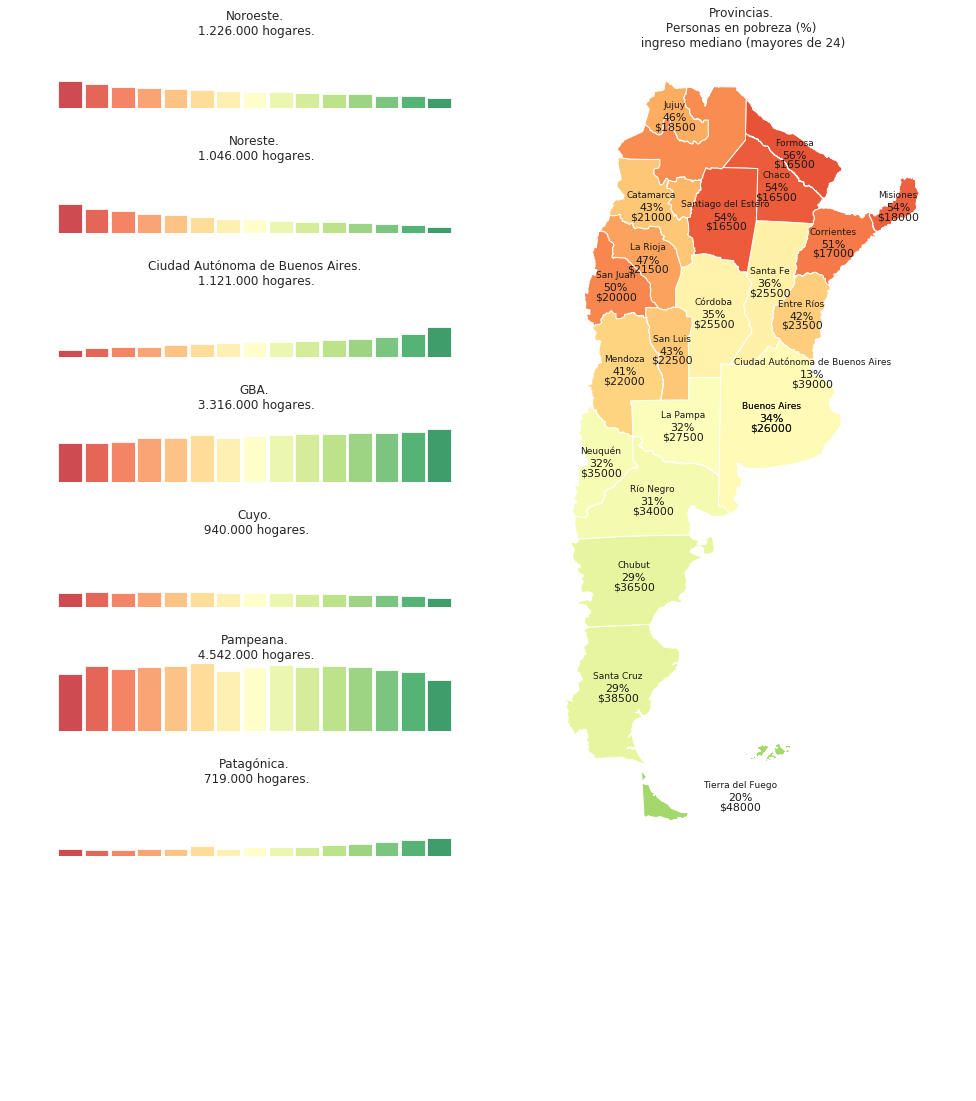

In [40]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize = (16, 15))
spec = gridspec.GridSpec(ncols=2, nrows=len(df), figure=fig)

for i in range(len(df)):
#     ax = axs[i]
    ax = fig.add_subplot(spec[i, 0])
    (df.iloc[i]/yrs_pob_data).plot(kind = 'bar', ax = ax, width = .9, color = sns.color_palette("RdYlGn", 15), alpha = .8)# colormap = 'RdYlGn')
    lugar = df.index[i]
    ax.set_title(lugar + '.\n '+str('{:,}'.format(int(np.round(tot_hogares.loc[lugar], -3))).replace(',', '.'))+' hogares.')
    ax.set_xlabel('Percentiles nacionales de ingreso', fontsize = 10)
    ax.set_ylim(0, 13000)
    ax.axis('off')
    plt.subplots_adjust(hspace = 0.85)
    

ax = fig.add_subplot(spec[:, 1])
# provs_gdf.plot(column = 'P47T_persona', ax = ax, vmin = 10000, vmax = 35000, cmap = 'RdYlGn')
provs_gdf.plot(column = 'Pobreza', ax = ax, vmin = 0, vmax = .66, cmap = 'RdYlGn_r')

# Encuadre ARG
# ax.set_xlim(-8300000, -5750000)
# ax.set_ylim(-7450000, -2400000)
ax.set_xlim(-.75e6, 1.25e6)
ax.set_ylim(-2.3e6, 1.6e6)

# ax.set_xlabel('A')
ax.axis('off')

for i, row in provs_gdf.drop([90, 66]).iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ingreso_mediano = '$'+str(int(myround(row.P47T_persona,500)))
    pobreza = str(int(round(100*row.Pobreza)))+'%'
#     ax.scatter(x, y, marker='x', color='red')
    ax.text(x, y + 40000, row.NOMPROV, fontsize=9, color = '.1', horizontalalignment = 'center')
    ax.text(x, y - 25000, pobreza, fontsize=11, color = '.1', horizontalalignment = 'center')
    ax.text(x, y - 70000, ingreso_mediano, fontsize=11, color = '.1', horizontalalignment = 'center')


# # regs_gdf.plot(color = 'None', edgecolor = 'k', ax = ax) Revisar
plt.title('Provincias.\n Personas en pobreza (%) \n ingreso mediano (mayores de 24)')
plt.show()

# fig.colorbar(im, ax=ax, orientation="horizontal")
# divider = make_axes_locatable(ax)
# cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")

# El error en ingreso medio por provincia esta en los 500 a 1000 pe
# En la cifra de pobreza el error es de 1%

In [41]:
import geopandas as gpd
dptos_gdf = gpd.read_file('./../../Documents/censo_geo/pxdptodatosok.shp').drop([439])
dptos_gdf['personas'] = pd.to_numeric(dptos_gdf['personas'])

data['link'] = data['DPTO'].astype(str).str.zfill(5)

pob_dpto = data.groupby('link')[['Pobreza']].mean().reset_index()

pob_dpto_gdf = gpd.GeoDataFrame(pob_dpto.merge(dptos_gdf))
# data.groupby('DPTO').count().iloc[:, 0].sort_values(ascending = False).head(10)

# pob_dpto_gdf.loc[pob_dpto_gdf.personas < 3000, 'Pobreza'] = np.nan
# pob_dpto_gdf = pob_dpto_gdf.fillna(pob_dpto_gdf.Pobreza.median())
# gdf = pob_dpto_gdf#.plot(column = 'Pobreza')

# fig, ax = plt.subplots(1, figsize = (6, 14))
# gdf.crs = {'init': 'epsg:4326'}
# gdf.to_crs({'init': 'epsg:3395'}).fillna(0).plot(column = 'Pobreza', ax = ax, vmin = -.1, vmax = .66, cmap = 'RdYlGn_r')
# plt.axis('off')
# plt.show()

## Tamaño de la vivienda. Hacinamiento.

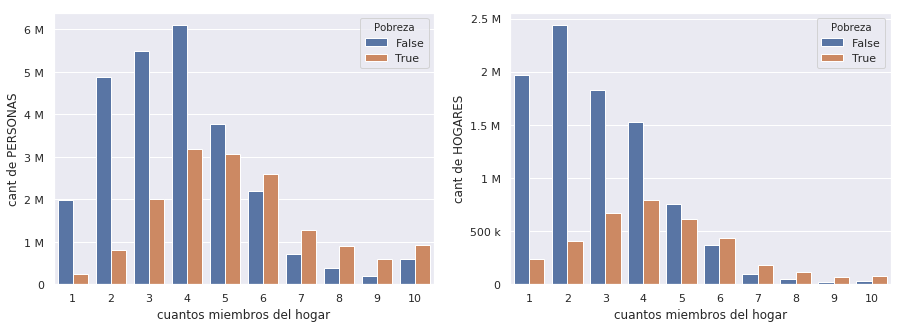

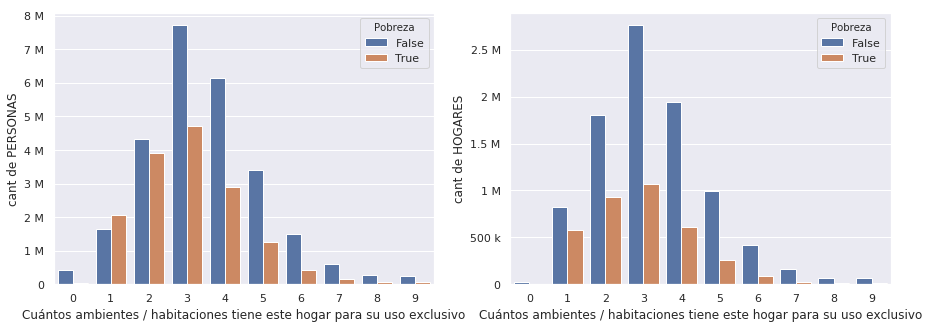

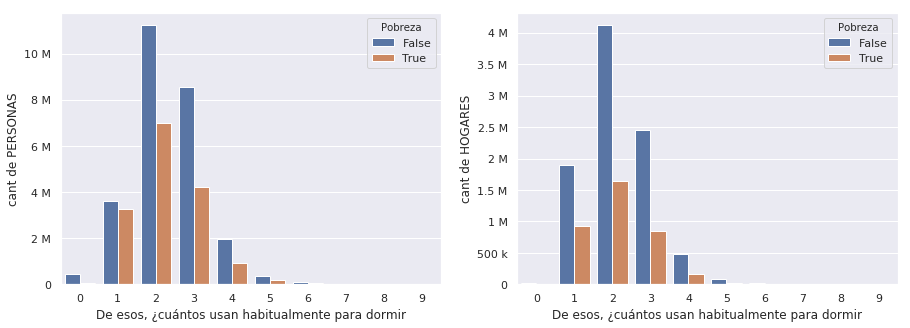

In [42]:

data = pd.read_csv('./data/pobreza'+str(frac)+'.csv', index_col=0)

import numpy as np
from matplotlib.ticker import EngFormatter
# cat_cols = ['V01', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10',
#        'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'PROP',
#        'P02', 'P05', 'P07', 'P08', 'P09', 'P10', 'CAT_OCUP',
#        'CAT_INAC', 'CH07', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59',
#        'PP07H', 'PP07I', 'PP07J', 'PP07K',
#        'AGLOMERADO', 'CONDACT', 'Grupo Etario'] # IX_TOT
# value_cols = 'P47T' #?

data['IX_TOT'] = np.clip(data.IX_TOT, 0, 10)
data['H15'] = np.clip(data.H15, 0, 9)

cat_cols = ['IX_TOT', 'H16', 'H15']

vn = pd.read_csv('./data/VARIABLE_NAMES.csv')
# vn['Pregunta'] = vn['Pregunta'].str.strip()#.str.replace("'", "") Don't run
# data = data.reset_index().rename(columns = {'index': 'PERSONA_REF_ID'}) # parche porque no esta la columna

for cat in cat_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    info = data.groupby([cat, 'Pobreza'])[['PERSONA_REF_ID', 'HOGAR_REF_ID']].nunique()
    info_pct = (100*(info.unstack()/info.unstack().sum()).stack())
    
    sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax1)
    xlab = ''
    try:
        xlab = vn.loc[vn.Censo == cat]['Pregunta'].values[0]
    except:
        try:
            xlab = vn.loc[vn.EPH == cat]['Pregunta'].values[0]
        except:
            pass
    ax1.set(xlabel= xlab, ylabel = 'cant de PERSONAS')
    ax1.yaxis.set_major_formatter(EngFormatter())
    sns.barplot(x=cat, y="HOGAR_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax2)
    ax2.set(xlabel= xlab, ylabel = 'cant de HOGARES')
    ax2.yaxis.set_major_formatter(EngFormatter())
    plt.show()

## Pobreza por grupo etario

In [43]:
# pd.cut(data.P03)

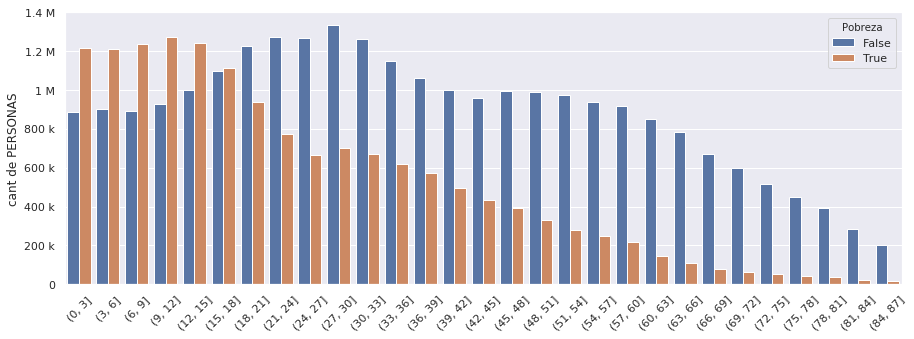

In [44]:
data['Grupo Etario'] = pd.cut(data.P03, np.arange(0, 90, 3))

cat = 'Grupo Etario'

vn = pd.read_csv('./data/VARIABLE_NAMES.csv')
# vn['Pregunta'] = vn['Pregunta'].str.strip()#.str.replace("'", "") Don't run

fig, ax = plt.subplots(1, figsize = (15, 5))
info = data.groupby([cat, 'Pobreza'])[['PERSONA_REF_ID']].nunique()
sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=(info/frac/yrs_pob_data).reset_index(), ax = ax)
xlab = ''
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(EngFormatter())
ax.set(xlabel= xlab, ylabel = 'cant de PERSONAS')
plt.show()

In [45]:
# ## Upper tail

# data['income_bin'] = pd.cut(np.log10(data['P47T_persona']).replace(-np.inf, 1), 100)

# fig, ax = plt.subplots(1, figsize = (5, 6))

# pdf_info = data.groupby('income_bin')['PERSONA_REF_ID'].count().reset_index()
# pdf_info['PERSONA_REF_ID'] = pdf_info['PERSONA_REF_ID']/frac/yrs_pob_data

# pdf_info['pdf'] = pdf_info['PERSONA_REF_ID']/pdf_info['PERSONA_REF_ID'].sum()
# pdf_info['cdf'] = pdf_info['pdf'].cumsum()

# np.log10(1 - pdf_info.iloc[60:85].set_index('income_bin')[['cdf']]).reset_index().plot(x = 'income_bin', y = 'cdf', marker = '.', ax = ax)
# ax.tick_params(axis='x', rotation=45)

# pdf_info.tail(20)

## Ingresos, pobreza e indigencia por niveles educativos

En este cuadro, los ingresos medios, porcentaje de pobreza e indigencia segun nivel educativo.

In [46]:
cuadro = pd.read_csv('./data/cuadro3_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
cuadro = cuadro.loc['2003':].drop(('P47T_persona', 'mean', 'Mayores de 24'), axis = 1)
cuadro.columns = ['Indigencia (%)', 'Ingresos (mediana)', 'Pobreza (%)']
cuadro = cuadro.unstack().mean().unstack().T

cuadro = cuadro[['Ingresos (mediana)', 'Pobreza (%)', 'Indigencia (%)']]
cuadro = cuadro.loc[[2, 20, 21, 40, 41, 60, 61, 70, 71, 80, 81]]

data_sel = data[['P03','P0910']]
counts = data_sel.loc[data_sel.P03 > 24]['P0910'].value_counts()
counts_pct = (100*counts.loc[[2, 20, 21, 40, 41, 60, 61, 70, 71, 80, 81]]/counts.sum()).round(1)

cuadro = pd.concat([cuadro, counts_pct], axis = 1)
cuadro = cuadro.rename(columns = {'P0910':'Poblacion (%)'})
cuadro.index = ['No asistió', 'Primaria', 'P. completa', 'Secundaria','S. completa', 'Terciario', 'T. completo', 
             'Universidad', 'U. completa', 'Postgrado', 'P. completo']

cuadro = cuadro.round({'Ingresos (mediana)': -2, 'Pobreza (%)': 1, 'Indigencia (%)': 1, 'Poblacion (%)': 1})
cuadro.style.bar(subset = ['Poblacion (%)'], vmin = 0)

,Ingresos (mediana),Pobreza (%),Indigencia (%),Poblacion (%)
No asistió,12200,50.7,17.8,2.2
Primaria,13100,49.1,17.2,13.2
P. completa,15400,43.5,13.2,27.5
Secundaria,19500,41.3,11.7,13.7
S. completa,25500,27.8,6.3,19.6
Terciario,26900,24.6,5.8,2.9
T. completo,32800,14.4,2.4,6.3
Universidad,31000,16.3,3.4,5.9
U. completa,48400,7,1.2,7
Postgrado,44600,7.7,1.7,0.4


*Mayores de 24 años

## Dependencia geografica
### Porcentaje de personas en pobreza por departamento.

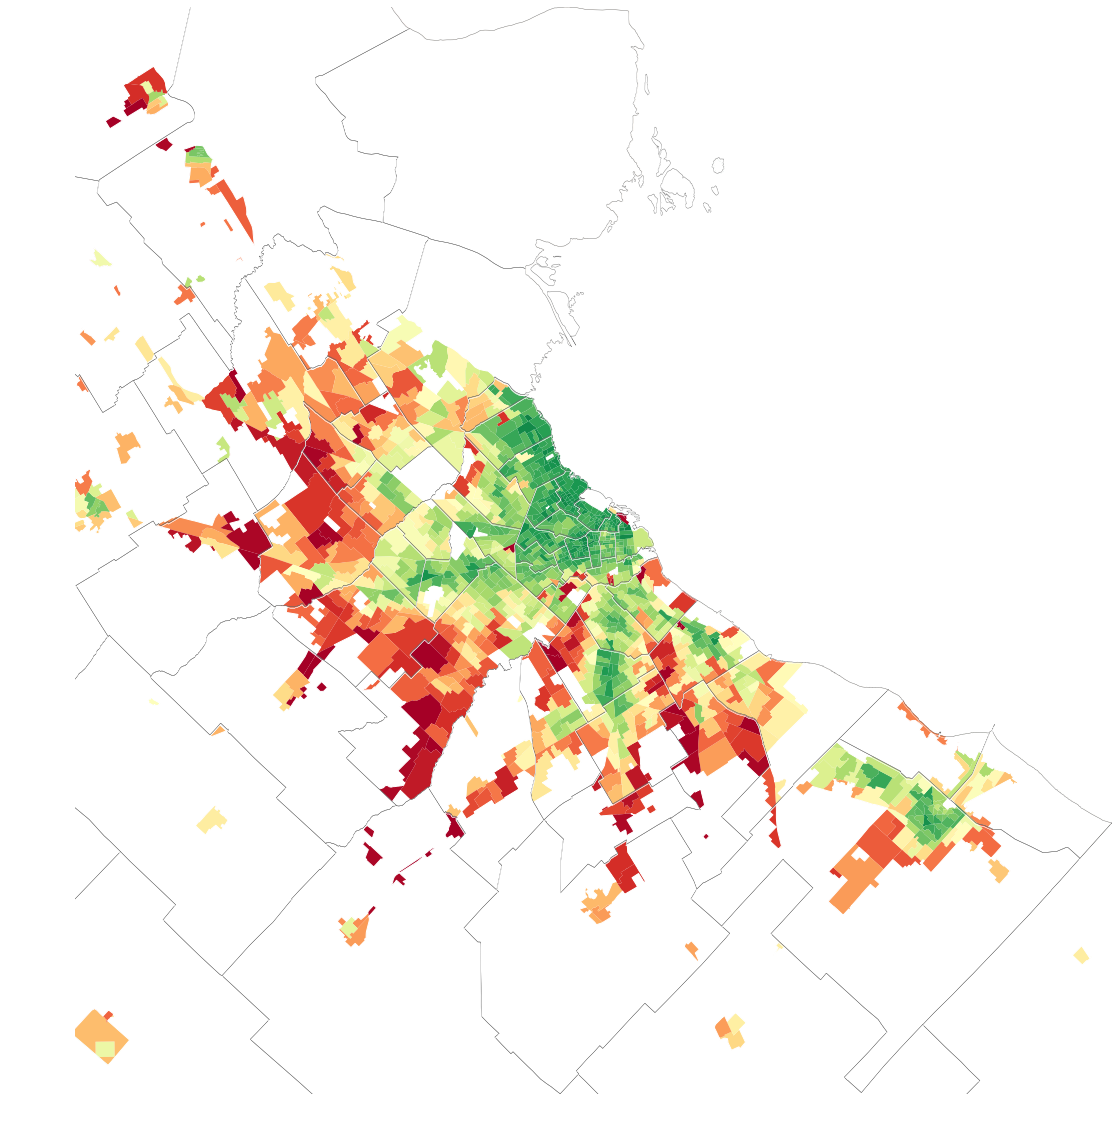

In [47]:
pob_frac = data.loc[data.PROV.isin([2, 6, 2])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.AGLOMERADO.isin([32])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.PROV.isin([82])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()
# pob_frac = data.loc[data.AGLOMERADO.isin([25])].groupby(['IDFRAC','DPTO'])[['Pobreza']].mean().reset_index()

frac_gdf = gpd.read_file('./../../Documents/censo_geo/pxfracdatosok.shp', )
pob_gdf = gpd.GeoDataFrame(pob_frac.merge(frac_gdf), crs = {'init': 'epsg:4326'})
# frac_gdf['personas'] = pd.to_numeric(frac_gdf['personas'])

# Fill na with median. Esp for areas of little pop.
# # data.groupby('DPTO').count().iloc[:, 0].sort_values(ascending = False).head(10)
# pob_gdf.loc[pob_gdf.personas < 3000, 'Pobreza'] = np.nan
# pob_gdf = pob_gdf.fillna(pob_dpto_gdf.Pobreza.median())

gdf = pob_gdf#.plot(column = 'Pobreza')

fig, ax = plt.subplots(1, figsize = (25, 20))
dptos_gdf.loc[dptos_gdf.codpcia.isin(['02', '06'])].to_crs({'init': 'epsg:3395'}).translate(yoff = 220, xoff = 30).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
dptos_gdf.loc[dptos_gdf.codpcia.isin(['02', '06'])].to_crs({'init': 'epsg:3395'}).translate(yoff = 0, xoff = 0).plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)
gdf.fillna(0).to_crs({'init': 'epsg:3395'}).plot(column = 'Pobreza', ax = ax, vmin = 0, vmax = .6, cmap = 'RdYlGn_r', lw = 0)
plt.axis('off')
# x1, y1, x2, y2 = tuple(gdf.fillna(0).to_crs({'init': 'epsg:3395'}).total_bounds)
x1, y1, x2, y2 = (-6583053, -4171597, -6424188, -4005023)
plt.xlim(x1, x2)
plt.ylim(y1, y2)

ejido = gpd.read_file('./../../Documents/censo_geo/ejidos/ejido_BA', driver='GeoJSON')
ejido.loc[[1]].to_crs({'init': 'epsg:3395'}).plot(color = 'w', ax = ax)
ejido
plt.savefig("./mapa_portada.png")
plt.show()

In [48]:
import geopandas as gpd
dptos_gdf = gpd.read_file('./../../Documents/censo_geo/pxdptodatosok.shp')
dptos_gdf.crs = {'init': 'epsg:4326'} #latlong
# dptos_gdf = dptos_gdf.to_crs({'init': 'epsg:3395'}) #lo dejamos en metrico
dptos_gdf['personas'] = pd.to_numeric(dptos_gdf['personas'])
dptos_gdf = dptos_gdf.to_crs(fancy_crs)

data['link'] = data['DPTO'].astype(str).str.zfill(5)
pob_dpto = data.groupby('link')[['Pobreza']].mean().reset_index()

pob_dpto['link'] = pob_dpto.link.astype(float).astype(int).astype(str).str.zfill(5)
pob_dpto_gdf = gpd.GeoDataFrame(pob_dpto.merge(dptos_gdf), crs = fancy_crs)
# data.groupby('DPTO').count().iloc[:, 0].sort_values(ascending = False).head(10)

pob_dpto_gdf.loc[pob_dpto_gdf.personas < 1300, 'Pobreza'] = np.nan
pob_dpto_gdf = pob_dpto_gdf.fillna(pob_dpto_gdf.Pobreza.median())
gdf = pob_dpto_gdf#.plot(column = 'Pobreza')


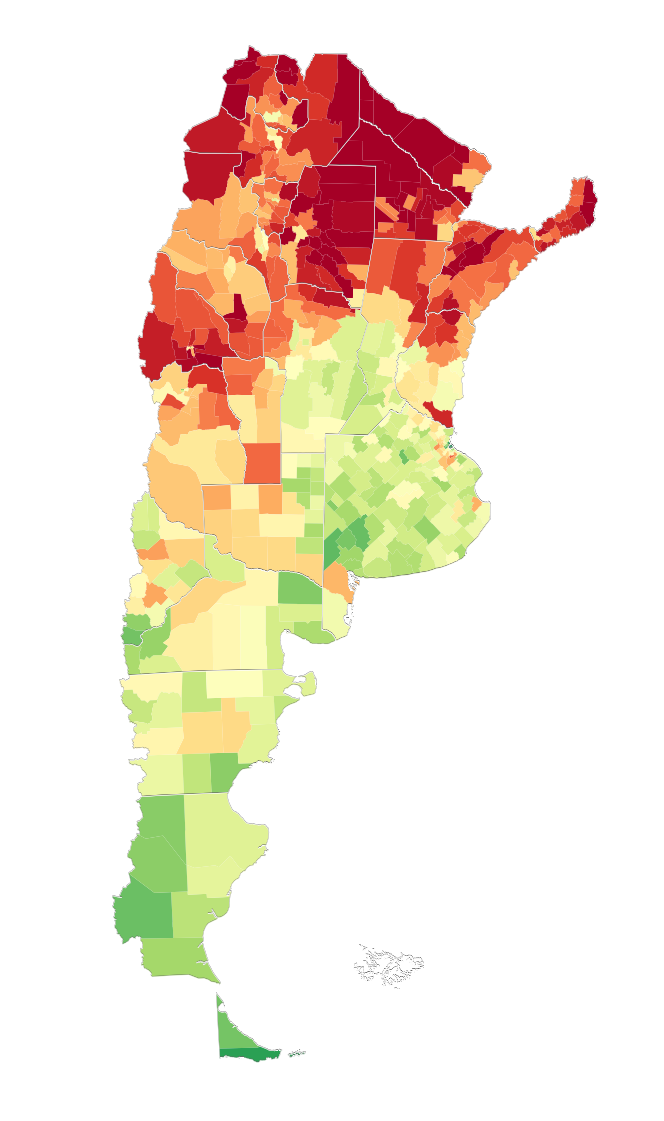

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

fig, ax = plt.subplots(1, figsize = (12, 20))
gdf.fillna(0).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r', lw = 0)

provs_gdf.translate(yoff = 2200, xoff = 300).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
provs_gdf.translate().plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

# # Encuadre ARG
ax.set_xlim(-.75e6, 1.25e6)
ax.set_ylim(-2.3e6, 1.6e6)
# ax.set_xlim(-8300000, -5750000)
# ax.set_ylim(-7450000, -2400000)
plt.axis('off')
plt.show()

### Porcentaje de personas en pobreza por fraccion censal.
#### Ejido Urbano AMBA

# Dependencia Temporal

In [50]:
# df = pd.read_csv('./data/cuadro_AGLO_si_Q_pct', index_col=[0, 1], header = [0, 1]).unstack(0, 1)
# df.index = pd.DatetimeIndex(df.index, freq = 'Q')

# df_ = df[['Indigencia', 'Pobreza']].groupby(pd.Grouper(level = 0, freq = '6MS')).mean().T
# df_.index = pd.MultiIndex.from_tuples([(x[0], x[1], 'Aglomerados' if x[2] else 'Resto') for x in df_.index])
# show = df_.copy()
# show.columns = show.columns.to_period("6M")
# show

### Porcentajes, 10 provincias. (2018)

In [51]:
cuadro2 = pd.read_csv('./data/cuadro1_'+str(frac)+'_ARG', index_col=[0, 1], header = [0, 1, 2])
df = cuadro2.iloc[:, cuadro2.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro2.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro2.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 1])
# x.columns = ['Fuera de aglomerados', 'Aglomerados']

# myround(x, 20).astype(int)
x.columns = x.columns.droplevel(1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

Indigencia          Pobreza         
                                   Hogares Personas Hogares Personas
NOMPROV                                                             
Formosa                               19.3     24.7    48.6     59.0
Chaco                                 18.2     23.5    47.0     57.4
Santiago del Estero                   18.0     23.1    46.9     57.5
Misiones                              17.2     22.5    46.5     57.8
Corrientes                            16.2     20.7    44.0     54.1
Salta                                 15.8     19.8    43.8     53.2
San Juan                              12.1     15.5    43.8     53.9
Jujuy                                 13.1     15.7    41.4     49.8
Tucuman                               13.0     15.8    39.9     48.5
La Rioja                              10.3     12.7    40.7     50.4
Catamarca                             12.6     16.5    37.6     47.2
San Luis                               8.9     12.0    36.6     47.2
Entre Rios                             9.7     13.5    35.7     45.9
Mendoza                                8.4     10.8    35.2     44.2
Santa Fe                               8.2     11.3    30.0     39.1
Cordoba                                7.6     10.2    30.0     38.6
Buenos Aires                           7.3      9.6    29.4     37.8
La Pampa                               7.1     10.1    26.9     36.0
Neuquen                                7.0      9.1    28.2     35.6
Rio Negro                              6.7      8.2    27.3     34.2
Chubut                                 5.9      7.0    25.3     31.5
Santa Cruz                             4.8      5.7    24.1     30.3
Tierra del Fuego                       3.5      4.1    16.8     21.6
Ciudad Autonoma de Buenos Aires        2.8      3.5    11.1     15.0

In [52]:
# # Niveles
# show = df.groupby(pd.TimeGrouper('Y', level = 0)).mean()
# show.columns = show.columns.droplevel(1)
# show.index = range(2007, 2019)

In [53]:
# diferencia
show = df.diff(4).groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0, 2).swaplevel(1,2)
show.index = range(startyr, endyr)

choice = np.random.choice(show.columns.get_level_values('NOMPROV').unique(), 10)

show.T.loc[choice].sort_index().round(1).style.applymap(color_negative_red)

## Niveles (%)
### Por Region y aglomerado. Promedio 2018.

In [54]:
cuadro = pd.read_csv('./data/cuadro0_'+str(frac)+'_ARG', index_col=[0, 1, 2], header = [0, 1, 2])
df = cuadro.iloc[:, cuadro.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro.columns.get_level_values(1).isin(['mean'])]

# Leave just time as index
df = df.unstack([1, 2]).dropna(1)
df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 4, 1]).dropna(1)
# # x.columns = ['Fuera de aglomerados', 'Aglomerados']
# # myround(x, 20).astype(int)
x.columns = x.columns.droplevel(-1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# # Rolling 4 trimestres de interpolado
# df = df.resample('Q').mean().interpolate()

Indigencia          Pobreza         
                                        Hogares Personas Hogares Personas
Region            NOMAGLO                                                
Noreste           Fuera de aglom.          20.2     26.4    50.9     62.3
Noroeste          Fuera de aglom.          18.9     23.8    50.0     60.3
Cuyo              Fuera de aglom.          11.6     15.2    43.1     53.7
Noreste           Formosa                  13.7     16.9    40.1     48.7
Pampeana          GBA                      11.7     15.2    41.5     50.9
                  Concordia                11.0     15.9    38.5     49.8
Noreste           Resistencia              12.5     15.1    38.2     46.3
                  Corrientes               12.7     15.3    37.3     46.0
Cuyo              San Juan                  9.8     12.5    38.9     48.6
                  La Rioja                  9.3     11.1    38.8     47.5
Noreste           Posadas                  11.5     14.4    35.6     45.1
Noroeste          Sgo del Estero           10.7     13.4    36.4     45.1
                  Salta                    10.6     12.9    34.7     42.2
                  Tucuman                  10.5     12.5    34.1     41.8
Cuyo              San Luis                  7.8     10.4    34.2     43.9
Noroeste          Jujuy                     9.4     10.8    34.1     41.0
                  Catamarca                 9.2     11.8    31.8     39.9
Pampeana          San Nicolas               8.2     10.7    31.8     41.2
                  Santa Fe                  9.2     12.6    30.1     39.5
                  Fuera de aglom.           7.7     10.8    30.7     40.2
Gran Buenos Aires GBA                       7.5      9.6    30.4     38.2
Pampeana          Parana                    7.3      9.8    28.6     36.6
Cuyo              Mendoza                   6.3      7.9    29.4     37.3
Pampeana          Cordoba                   7.1      9.4    27.7     36.1
Patagónica        Fuera de aglom.           7.0      8.6    28.7     35.5
Pampeana          Rosario                   7.4      9.8    27.4     35.1
                  Viedma-Patagones          5.8      8.5    25.8     36.5
                  Rio Cuarto                6.1      8.3    25.7     33.5
Patagónica        Rawson-Trelew             6.0      7.6    25.9     33.8
                  Neuquen                   5.8      7.3    25.0     31.9
Pampeana          Santa Rosa                6.1      8.5    23.4     31.8
                  La Plata                  5.8      8.0    23.4     31.3
                  Mar del Plata             5.5      7.9    22.7     30.7
                  Bahia Blanca              5.1      6.6    22.3     29.4
Patagónica        Viedma-Patagones          4.2      5.5    21.9     28.5
                  Rio Gallegos              4.2      5.4    20.3     26.3
                  Cdro Rivadavia            4.0      4.6    19.5     25.0
Gran Buenos Aires Fuera de aglom.           3.9      5.0    12.9     18.1
Patagónica        Ushuaia-Rio Grande        2.9      3.1    14.6     18.5
Gran Buenos Aires CABA                      2.8      3.5    11.1     15.0

## Cambio en niveles (%)
### Por aglomerado en regiones.

In [55]:
# diferencia
show = df.diff(4).groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0,2).swaplevel(1,3)
show.index = range(startyr, endyr)

# choice = np.random.choice(, 10)
show = show.T.sort_index().round()

for region in show.index.get_level_values('Region').unique():
    display(md('#### '+region))
    display(show.loc[region].style.applymap(color_negative_red))

#### Cuyo

#### Gran Buenos Aires

#### Noreste

#### Noroeste

#### Pampeana

#### Patagónica

## Niveles (%)
### Partidos y Comunas del AMBA (muestreo)

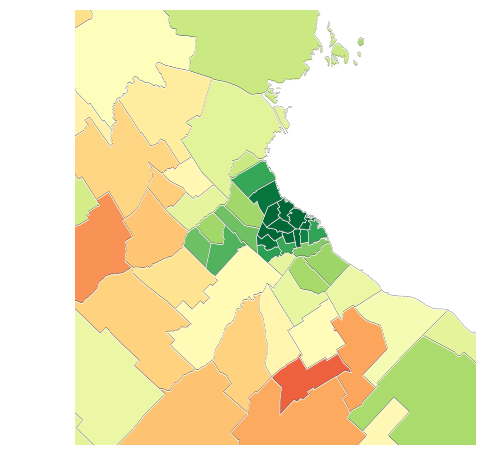

Indigencia          Pobreza         
                       Hogares Personas Hogares Personas
Presidente Perón          14.9     18.4    49.4     58.9
Marcos Paz                14.2     18.4    47.1     58.1
General Rodríguez         12.2     16.4    42.2     53.0
Florencio Varela          12.4     15.6    43.5     52.1
José C. Paz               12.1     14.8    43.0     51.6
San Vicente               12.5     15.8    41.7     50.6
Moreno                    11.4     14.1    41.5     49.5
Ezeiza                    10.7     13.1    41.6     50.1
Pilar                     10.9     14.4    40.4     49.6
Escobar                   10.4     13.3    38.3     46.8
Merlo                     10.0     12.6    38.8     47.3
Malvinas Argentinas        9.0     11.5    35.8     43.0
La Matanza                 8.4     10.4    34.5     42.1
Esteban Echeverría         8.3     10.0    34.7     42.0
Almirante Brown            8.4     10.9    33.5     41.6
Berazategui                7.4      9.5    31.3     39.0
Ensenada                   7.3      9.0    30.1     39.0
San Miguel                 7.4     10.0    29.8     37.8
Tigre                      7.3      9.0    30.8     37.6
Comuna 08                  8.6     10.6    28.9     36.6
Lomas de Zamora            7.2      9.1    29.0     36.6
Quilmes                    7.1      9.1    28.8     36.7
Berisso                    6.7      8.8    27.9     36.4
San Fernando               6.2      8.0    26.0     33.9
Hurlingham                 5.6      6.8    24.6     30.8
La Plata                   5.6      7.8    22.4     30.0
General San Martín         5.0      6.4    23.1     29.9
Lanús                      5.2      6.6    22.7     29.3
Avellaneda                 4.9      6.5    22.4     29.2
Comuna 04                  5.1      7.1    19.3     26.9
Ituzaingó                  4.6      5.5    21.6     25.3
Tres de Febrero            3.7      4.8    19.2     24.6
Morón                      3.2      4.1    17.0     22.5
Comuna 01                  4.3      5.3    14.7     18.8
Comuna 07                  3.2      4.3    14.7     20.1
San Isidro                 3.5      4.4    15.1     19.2
Comuna 09                  3.0      4.1    13.9     18.3
Comuna 03                  2.5      3.2    10.7     14.5
Vicente López              2.3      2.7    10.9     13.8
Comuna 10                  2.0      3.0     9.7     13.2
Comuna 15                  2.2      2.5     9.6     12.2
Comuna 05                  1.8      2.1     7.8     10.5
Comuna 11                  1.4      1.6     7.9     10.4
Comuna 14                  2.2      2.0     7.4      8.8
Comuna 02                  2.4      2.1     7.2      8.1
Comuna 12                  1.4      1.6     7.0      8.9
Comuna 06                  1.4      1.3     6.8      8.6
Comuna 13                  1.6      1.4     6.5      7.5

In [56]:
fig, ax = plt.subplots(1, figsize = (8, 8))
gdf.fillna(0).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r',
                                                 edgecolor = '.4', lw = 0)
#Partidos b&n
gdf.to_crs({'init': 'epsg:3395'}).fillna(0).plot(column = 'Pobreza', ax = ax, vmin = .1, vmax = .65, cmap = 'RdYlGn_r',
                                                 edgecolor = '.4', lw = 0)
dptos_gdf.to_crs({'init': 'epsg:3395'}).loc[dptos_gdf.to_crs({'init': 'epsg:3395'}).codpcia.isin(['02', '06'])].translate(yoff = 220, xoff = 30).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
dptos_gdf.to_crs({'init': 'epsg:3395'}).loc[dptos_gdf.to_crs({'init': 'epsg:3395'}).codpcia.isin(['02', '06'])].translate(yoff = 0, xoff = 0).plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

plt.xlim(-6570000, -6450000)
plt.ylim(-4150000, -4020000)
# ax.set_xlim(530e5, 7e5)
# ax.set_ylim(-25000, 75000)
plt.axis('off')

plt.show()


cuadro = pd.read_csv('./data/cuadro5_'+str(frac)+'_AMBA', index_col=[0, 1], header = [0, 1, 2])
df = cuadro.iloc[:, cuadro.columns.get_level_values(0).isin(['Indigencia', 'Pobreza'])
            & cuadro.columns.get_level_values(2).isin(['Hogares', 'Personas'])
                 & cuadro.columns.get_level_values(1).isin(['mean'])]

# Dptos de codigo a nombres...
dptos = pd.read_csv('./data/radio_ref.csv')[['DPTO','NOMDPTO']].drop_duplicates().set_index('DPTO')
nomdptos = dptos.to_dict()['NOMDPTO']
df.index = pd.MultiIndex.from_tuples([(x[0], nomdptos[x[1]]) for x in df.index])

# Leave just time as index
df = df.unstack()

df.index = pd.DatetimeIndex(df.index)

# Ultimo periodo
x = df.loc['2018'].mean().unstack([3, 1])
# x.columns = ['Fuera de aglomerados', 'Aglomerados']

# myround(x, 20).astype(int)
x.columns = x.columns.droplevel(1)
display(x.T.reindex(x.T.sum(1).sort_values(ascending = False).index).round(1))

# Rolling 4 trimestres de interpolado
df = df.resample('Q').mean().interpolate()

## Cambio en niveles (%)

In [57]:
# diferencia
show = df.diff(4).groupby(pd.TimeGrouper('Y', level = 0)).mean()
show.columns = show.columns.droplevel(1)
show.columns = show.columns.swaplevel(0, 2).swaplevel(1,2)
show.index = range(startyr, endyr)

choice = np.random.choice(show.columns.get_level_values(0).unique(), 10)

show.T.loc[choice].sort_index().round(1).style.applymap(color_negative_red)

## Lista de Aglomerados
Y su poblacion (miles)

In [12]:
## Appendix
data = pd.read_csv('./data/pobreza'+str(frac)+'.csv', usecols = ['DPTO', 'PERSONA_REF_ID', 'AGLOMERADO'])

aglo_labels = pd.read_csv('./data/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = pd.read_csv('./data/radio_ref.csv').merge(aglo_labels)
data = data.merge(radio_ref[['DPTO','NOMAGLO', 'NOMPROV', 'NOMDPTO']].drop_duplicates())

pd.options.display.max_rows = 999
poblacion_por_aglo_dpto = data.loc[data.AGLOMERADO != 0].groupby(['NOMAGLO', 'NOMPROV', 'NOMDPTO'])[['PERSONA_REF_ID']].count().sort_index()/frac/yrs_pob_data/1e3
poblacion_por_aglo_dpto.columns = ['Poblacion (miles)']
poblacion_por_aglo_dpto.drop('Fuera de aglom.').round().style.bar(vmin = 0)

# poblacion (miles)